# Ball and stick 4: Parallel vs serial mode

This is the final part of the series where we build a multicompartment cell and evolve it into a network of cells running on a parallel machine (which is basically all computers made within the last decade). On this page, we translate the classes we have previously constructed so that they operate in either a parallel or serial mode.

**Note:** If you followed the [installation instructions](../install/install_instructions.html) on the NEURON website, you should have everything you need to run parallel simulations.
If not, if you do not already have an MPI installation, go to that link and follow the instructions related to MPI.
If you compiled NEURON yourself instead of using an installer (this is rarely necessary), this part of the tutorial requires you to have used the `-DNRN_ENABLE_MPI=ON` flag at configure time.

## Parallel communication in NEURON

Parallel communication takes place via logical events in network connection objects known as [NetCon](../python/modelspec/programmatic/network/netcon.html).
NetCon sources are threshold detectors. They monitor some variable, say the membrane potential of a cell, and when the variable reaches some threshold, it triggers an event sent to the targets. Targets are frequently synapses on other cells. When they receive the event, they activate.

In a parallel context across several machines, communication between hosts can be computationally inefficient when the frequency of events is high and when the message being sent is large. NEURON uses an efficient priority queueing mechanism to deliver events to targets after the delay specified by the NetCon. The message passed is succinct. It is an integer, the unique global identifier (gid) of the source.
The following two figures illustrate these ideas and come from [Hines M.L. and Carnevale N.T, Translating network models to parallel hardware in NEURON, Journal of Neuroscience Methods 169 (2008) 425–455](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2430920).
Users should also consult the [ParallelContext](../python/modelspec/programmatic/network/parcon.html) reference.

<center><img src="https://neuron.yale.edu/neuron/static/docs/neuronpython/_images/parfig2.1.png"/></center>

<center><img src="https://neuron.yale.edu/neuron/static/docs/neuronpython/_images/parfig2.2.png"/></center>

The main step involved in making a parallel implementation is to assign the global identifiers across the various hosts. Care should also be taken to assign cells to the various hosts such that the system is load balanced. For example, in a network with computationally complex and simple cells, several simple cells may be assigned to a host while few complex cells may be assigned to another host.

## Test MPI and Parallel NEURON

Once again, parallel NEURON requires MPI support. If this is your first time using it in a while, you should test your computer setup.

To do this, first we will write out a small test script.
Executing the following cell will create a file called `testmpi.py`:

In [1]:
%%writefile testmpi.py
from neuron import h
h.nrnmpi_init()       # initialize MPI
pc = h.ParallelContext()
print('I am {} of {}'.format(pc.id(), pc.nhost()))
h.quit()              # necessary to avoid a warning message on parallel exit on some systems

Writing testmpi.py


And we will test running this script using `mpiexec`.
Normally we can just write `python` in place of `$python_exe`, but using `sys.executable` in this way can be necessary on systems with multiple Python versions.

In [2]:
import os, sys

os.environ["python_exe"] = sys.executable

Now we can run the script in parallel with `mpiexec -n 4 python testmpi.py`.

You can also run this directly from the command line in a terminal; most likely this is what you will want to do when running larger simulations or using a shared compute cluster.

In [3]:
!mpiexec -n 4 $python_exe testmpi.py

--------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 4
slots that were requested by the application:

  /opt/hostedtoolcache/Python/3.12.4/x64/bin/python

Either request fewer slots for your application, or make more slots
available for use.

A "slot" is the Open MPI term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which Open MPI processes are run:

  1. Hostfile, via "slots=N" clauses (N defaults to number of
     processor cores if not provided)
  2. The --host command line parameter, via a ":N" suffix on the
     hostname (N defaults to 1 if not provided)
  3. Resource manager (e.g., SLURM, PBS/Torque, LSF, etc.)
  4. If none of a hostfile, the --host command line parameter, or an
     RM is present, Open MPI defaults to the number of processor cores

In all the above cases, if you want Open MPI to default to the number
o

You should see something similar to:
```bash
numprocs=4
I am 1 of 4
I am 2 of 4
I am 3 of 4
I am 0 of 4
```

These could appear in any order since in theory they are running simultaneously but must print out in some order.
If instead you see four processes claiming to be 0 of 1, then your copy of NEURON was not compiled with support for parallel simulation.
Reconfigure with the [-DNRN_ENABLE_MPI=ON flag](../cmake_doc/options.html#mpi-options), recompile, and try again.

If you get an error saying that `mpiexec` is an unknown command, then MPI is either not installed or not on your PATH; correct your MPI setup and try again.

## Back to the example

This notebook requires that `ballandstick.py` is in your working directory.
This is equivalent to the classes we created in the previous part of the tutorial.

We will construct a `ring.py` based on the previous `Ring` class. Changes are indicated with `###`:

In [4]:
%%writefile ring.py
from neuron import h
from ballandstick import BallAndStick

### MPI must be initialized before we create a ParallelContext object
h.nrnmpi_init()
pc = h.ParallelContext()

class Ring:
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """
    def __init__(self, N=5, stim_w=0.04, stim_t=9, stim_delay=1, syn_w=0.01, syn_delay=5, r=50):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """ 
        self._N = N
        self.set_gids()                   ### assign gids to processors
        self._syn_w = syn_w
        self._syn_delay = syn_delay
        self._create_cells(r)             ### changed to use self._N instead of passing in N
        self._connect_cells()
        ### the 0th cell only exists on one process... that's the only one that gets a netstim
        if pc.gid_exists(0):
            self._netstim = h.NetStim()
            self._netstim.number = 1
            self._netstim.start = stim_t
            self._nc = h.NetCon(self._netstim, pc.gid2cell(0).syn)   ### grab cell with gid==0 wherever it exists
            self._nc.delay = stim_delay
            self._nc.weight[0] = stim_w
    
    def set_gids(self):
        """Set the gidlist on this host."""
        #### Round-robin counting.
        #### Each host has an id from 0 to pc.nhost() - 1.
        self.gidlist = list(range(pc.id(), self._N, pc.nhost()))
        for gid in self.gidlist:
            pc.set_gid2node(gid, pc.id())
    
    def _create_cells(self, r):
        self.cells = []
        for i in self.gidlist:    ### only create the cells that exist on this host
            theta = i * 2 * h.PI / self._N
            self.cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
        ### associate the cell with this host and gid
        for cell in self.cells:
            pc.cell(cell._gid, cell._spike_detector)

    def _connect_cells(self):
        ### this method is different because we now must use ids instead of objects
        for target in self.cells:
            source_gid = (target._gid - 1 + self._N) % self._N
            nc = pc.gid_connect(source_gid, target.syn)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            target._ncs.append(nc)

Writing ring.py


The call to `h.nrnmpi_init()` must happen before any use of the [ParallelContext](../python/modelspec/programmatic/network/parcon.html) class -- which forms a key part of any NEURON parallel simulation.

The only conceptually new method here is the `set_gids` method where each process specifies which cells it will simulate. Here we use what is known as a round-robin approach, where the `pc.id()`th process starts at `pc.id()` and skips by however many processes are running (`pc.nhost`).

In `_create_cells`, we now associate the cell `gid` with the NetCon `_spike_detector`. This allows the `_connect_cells` to make connections based on gids instead of objects, using `pc.gid_connect`.

## Test the model

Here's a basic test, `test_ring1.py` that loads the `Ring` class and plots cell 0's membrane potential timeseries:

In [5]:
%%writefile test_ring1.py
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
from ring import Ring

cell_to_plot = 0

ring = Ring()

pc = h.ParallelContext()
pc.set_maxstep(10 * ms)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
pc.psolve(100 * ms)

if pc.gid_exists(cell_to_plot):
    plt.figure()
    plt.title("Cell {}".format(cell_to_plot))
    plt.plot(t, pc.gid2cell(cell_to_plot).soma_v)
    plt.xlabel("Simulation time [ms]")
    plt.ylabel("Soma voltage [mV]")
    plt.savefig("test_ring1_{}ranks.svgz".format(pc.nhost()))

pc.barrier()
pc.done()
h.quit()

Writing test_ring1.py


The code above should look very familiar.

The conceptually new pieces are:

* [pc.set_maxstep(10 * ms)](../python/modelspec/programmatic/network/parcon.html#ParallelContext.set_maxstep) -- sets an upper bound on how far MPI can simulate without communicating, here a simulated 10 ms. This *must* be called before attempting a parallel simulation.
* [pc.psolve(100 * ms)](../python/modelspec/programmatic/network/parcon.html#ParallelContext.psolve) -- a parallel version of [h.continuerun](../python/simctrl/stdrun.html), but does not support updating NEURON graphics during the simulation.
* [pc.gid_exists](../python/modelspec/programmatic/network/parcon.html#ParallelContext.gid_exists)  -- only the process that owns the specified cell should make the plot.
* [pc.gid2cell](../python/modelspec/programmatic/network/parcon.html#ParallelContext.gid2cell) -- lookup a cell by gid.
* [pc.barrier()](../python/modelspec/programmatic/network/parcon.html#ParallelContext.barrier) -- wait until all processes reach this point; used to make sure processes don't shut down before the graph is closed.

Start by testing this without using MPI:

numprocs=1


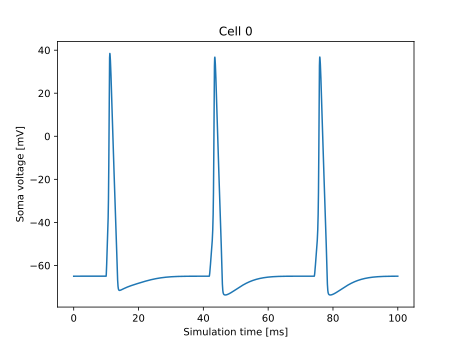

In [6]:
!$python_exe test_ring1.py


def SVGZ(name):
    from gzip import GzipFile
    from IPython.display import SVG

    return SVG(data=GzipFile(name + ".svgz").read())


SVGZ("test_ring1_1ranks")

This should look similar to the following reference image:

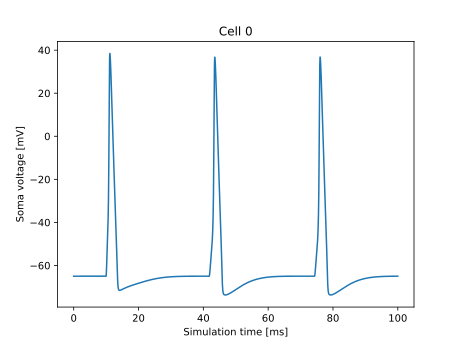

In [7]:
SVGZ("test_ring1_ref")

And once you are satisfied that works, you can try MPI, e.g.

numprocs=2


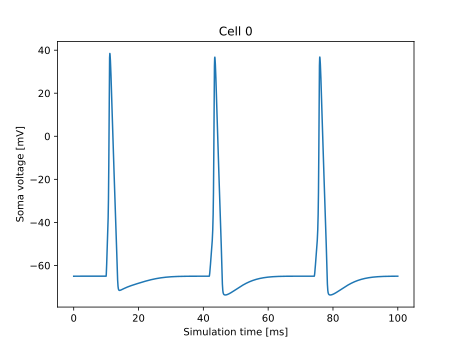

In [8]:
!mpiexec -n 2 $python_exe test_ring1.py
SVGZ("test_ring1_2ranks")

## Gathering spikes

Our above test runs the simulation successfully, but in the end, no single process knows when all the spikes occurred.
There are a number of ways to deal with this: one solution is to have each process write its data to a file.
Instead, we will use [pc.py_alltoall](../python/modelspec/programmatic/network/parcon.html#ParallelContext.py_alltoall) to send all the data to MPI rank 0 (`pc.id() == 0`), at which point it can plot the raster, save data, or whatever.

The following code does this and saves itself to a file called `test_ring2.py`:

In [9]:
%%writefile test_ring2.py
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
from ring import Ring

ring = Ring()

pc = h.ParallelContext()
pc.set_maxstep(10 * ms)

t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
pc.psolve(100 * ms)

# send all spike time data to rank 0
local_data = {cell._gid: list(cell.spike_times) for cell in ring.cells}
all_data = pc.py_alltoall([local_data] + [None] * (pc.nhost() - 1))

if pc.id() == 0:
    # combine the data from the various processes
    data = {}
    for process_data in all_data:
        data.update(process_data)
    # plot it
    plt.figure()
    plt.title("Spike raster")
    plt.xlabel("Simulation time [ms]")
    plt.ylabel("Cell")
    for i, spike_times in data.items():
        plt.vlines(spike_times, i + 0.5, i + 1.5)
    plt.savefig("test_ring2.svgz")

pc.barrier()
pc.done()
h.quit()

Writing test_ring2.py


We can run this using `mpiexec` as before, here with two processes:

numprocs=2


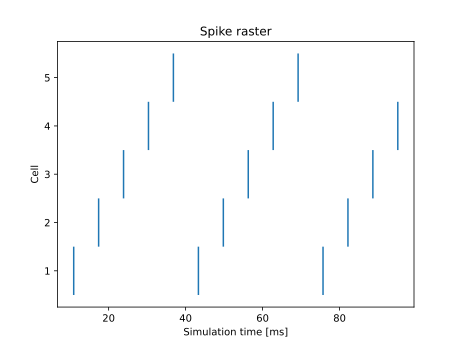

In [10]:
!mpiexec -n 2 $python_exe test_ring2.py
SVGZ("test_ring2")

This should display the familiar raster plot.
If you are wondering why node 0 was the one chosen to make the plot, it is because that is the only node that is guaranteed to exist (nothing else exists if there is only one process being used for the simulation).
A reference version of the raster plot is shown below; the two plots should look the same:

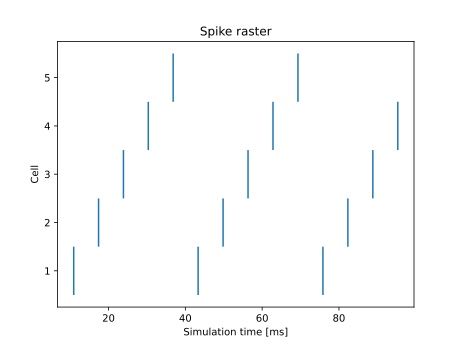

In [11]:
SVGZ("test_ring2_ref")